In [ ]:
# this code is based on [ref], which is released under the MIT licesne
# make sure you reference any code you have studied as above here
 
# imports
import math
import secrets
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
 
from IPython.display import clear_output
 
# hyperparameters
batch_size  = 64
n_channels  = 3
# latent_size = 128
latent_size = 32
dataset = 'horse_birds'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# optional Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x


cifar_10 = torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True,transform=torchvision.transforms.Compose([
             torchvision.transforms.ToTensor(),
             ]))

stl_10 = torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train+unlabeled', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(32),
            torchvision.transforms.ToTensor(),
        ]))


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
full_set = None
if dataset == 'horse_birds':
    idx = torch.tensor(cifar_10.targets) == 2
    idx += torch.tensor(cifar_10.targets) == 7
    cifar_set = torch.utils.data.Subset(cifar_10, np.where(idx==1)[0])
    idx = torch.tensor(stl_10.labels) == 1
    idx += torch.tensor(stl_10.labels) == 6
    stl_set = torch.utils.data.Subset(stl_10, np.where(idx==1)[0])
    full_set = torch.utils.data.ConcatDataset([cifar_set, stl_set])
else:
    full_set = torch.utils.data.ConcatDataset([cifar_10, stl_10])
print(len(full_set))
train_loader = torch.utils.data.DataLoader(full_set, shuffle=True, batch_size=64, drop_last=True)
train_iterator = iter(cycle(train_loader))

155000


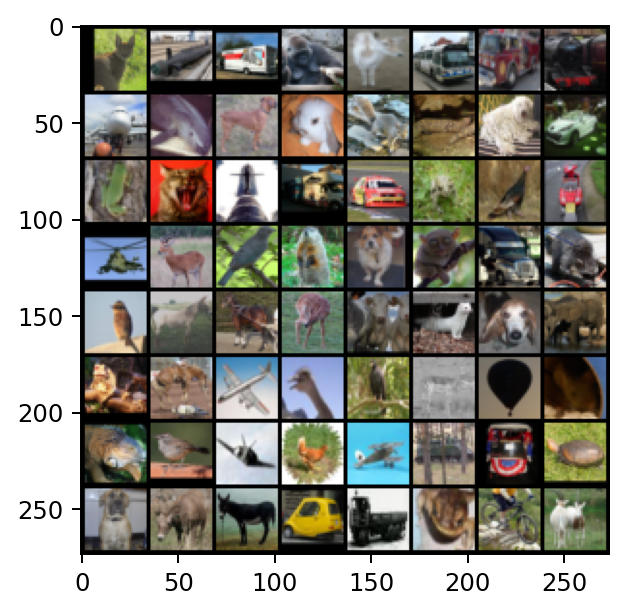

In [ ]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 175
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

**Define a simple convolutional variational autoencoder**

In [ ]:

# define the model
class Autoencoder(nn.Module):
    def __init__(self, f=16):
        super().__init__()

        self.meanLayer = nn.Linear(512, latent_size)
        self.varLayer = nn.Linear(512, latent_size)

        self.fcset1 = nn.Sequential(
            nn.Linear(8192, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.LeakyReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True)
        )

        self.fcset2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(inplace=True),
            nn.Linear(2048, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Linear(4096, 8192),
            nn.LeakyReLU(inplace=True)
        )


        self.preDecode = nn.Linear(latent_size, 512)

        self.pre_encode = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(16, n_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparamterise(self, means, vars):
      if self.training:
        std = torch.exp(0.5*vars)
        noise = torch.rand_like(std)
        return means + noise * std
      else:
        return means


    def encode(self, data):
      pre = self.pre_encode(data)
      pre = pre.view(pre.size(0), -1)
      pre = self.fcset1(pre)
      return self.meanLayer(pre), self.varLayer(pre)

    def decode(self, data):
      pre = self.preDecode(data)
      pre = self.fcset2(pre)
      pre = pre.view(pre.size(0), 128, 8, 8)
      return self.decoder(pre)

    def forward(self, data):
      means, vars = self.encode(data)
      out = self.reparamterise(means, vars)
      return self.decode(out), means, vars


A = Autoencoder().to(device)
print(f'> Number of autoencoder parameters {len(torch.nn.utils.parameters_to_vector(A.parameters()))}')
optimiser = torch.optim.Adam(A.parameters(), lr=1e-4)


> Number of autoencoder parameters 89405027


**Vae Loss Function**

In [ ]:
def vae_loss(decodedX, orgX, means, vars):
  # sum BCE over all features in batch, then div by batch size to get mean
  crossEntropy = F.binary_cross_entropy(decodedX, orgX, reduction='sum') / batch_size

  kld = -0.5 * torch.sum(1 + vars - means.pow(2) - vars.exp(), dim=1).mean()
  
  return crossEntropy + kld

**Main training loop**

In [ ]:
A.train()
for epoch in range(100):
    # array(s) for the performance measures
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for x, _ in train_loader:

        # sample x from the dataset
        x = x.to(device)

        z, means, vars = A(x)
        loss = vae_loss(z, x, means, vars)

        # backpropagate to compute the gradient of the loss w.r.t the parameters and optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    # sample your model (autoencoders are not good at this)
    z = torch.randn(64, latent_size).to(device)
    g = A.decode(z)

    # plot some examples
    print('epoch '+str(epoch)+' loss ' + str(loss.mean()))
    plt.rcParams['figure.dpi'] = 100
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g[:8]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)

torch.save({'A':A.state_dict(), 'optimiser':optimiser.state_dict(), 'epoch':epoch}, 'drive/My Drive/training/conv_stl_full.chkpt')
clear_output()

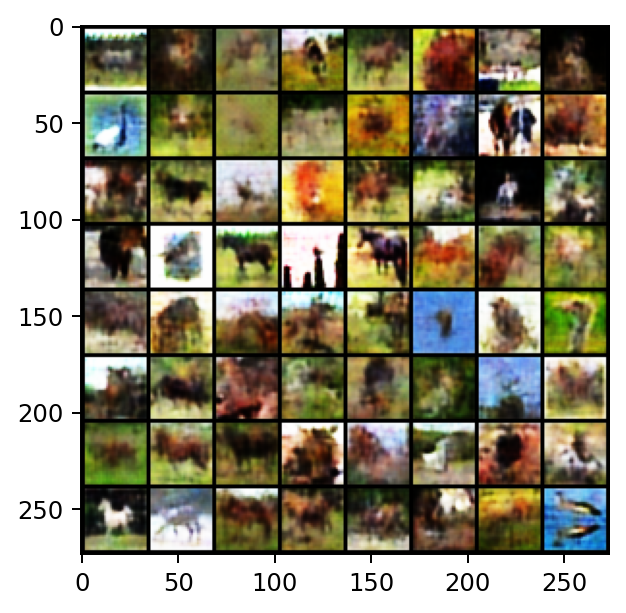

In [ ]:
A.eval()
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
g, means, vars = A(x)

plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

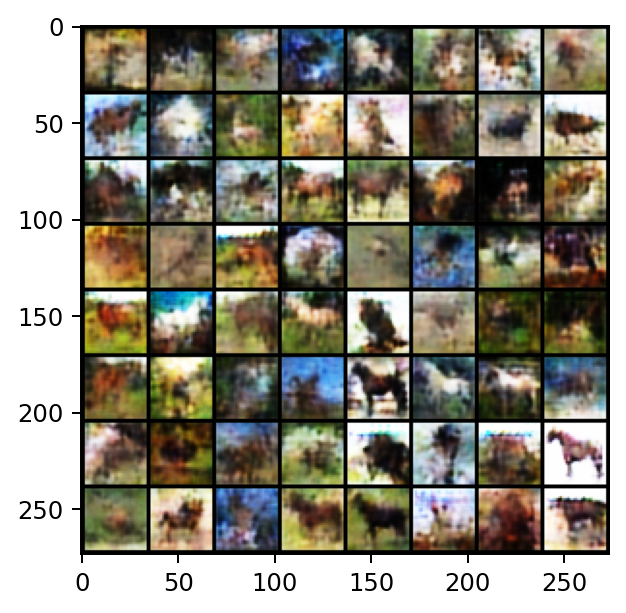

In [ ]:
# Random samples to get an idea of how good the model is
A.eval()
z = torch.randn(64, latent_size).to(device)
g = A.decode(z)
plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
# optional example code to save your training progress for resuming later if you authenticated Google Drive previously
torch.save({'A':A.state_dict(), 'optimiser':optimiser.state_dict(), 'epoch':epoch}, 'drive/My Drive/training/save.chkpt')

In [ ]:
# optional example to resume training if you authenticated Google Drive previously
params = torch.load('drive/My Drive/training/conv_stl_horse.chkpt')
A.load_state_dict(params['A'])
optimiser.load_state_dict(params['optimiser'])
epoch = params['epoch']

In [ ]:
# Generate samples

def slerp(v1, v2, frac):
  O = torch.acos((v1/torch.norm(v1, keepdim=True)) * (v2/torch.norm(v2, keepdim=True)))
  out = (torch.sin((1-frac)*O)/torch.sin(O))*v1 + (torch.sin(frac*O)/torch.sin(O)) * v2
  return out

horses = [1916, 1860, 9588, 2386, 2388, 2688, 2694, 2699]
birds = [1091, 1107, 1224, 1227, 1456, 1551, 1723, 2631, 2823, 2860, 3097, 4107, 4147, 6983, 7359, 7297, 9808]

browse_loader = torch.utils.data.DataLoader(full_set, shuffle=False, batch_size=batch_size, drop_last=True)
browse_iterator = iter(cycle(browse_loader))
res = []
for i in range(8):
  bird_idx = secrets.choice(birds)
  horse_idx = secrets.choice(horses)
  bird, _ = full_set[bird_idx]
  horse, _ = full_set[horses[i]]
  bird = bird.unsqueeze(0)
  horse = horse.unsqueeze(0)
  bird = bird.to(device)
  horse = horse.to(device)
  bird_code, _ = A.encode(bird)
  horse_code, _ = A.encode(horse)
  fracs = np.linspace(0.4,0.7,8)
  mini_res = []
  for f in fracs:
    mid = slerp(bird_code, horse_code, f)
    mid = A.decode(mid)
    mid = mid.cpu()
    mid = mid.detach().numpy()
    mid = torch.tensor(mid)
    mid = mid.squeeze(0)
    mini_res.append(mid)
  res.append(mini_res)


plt.rcParams['figure.dpi'] = 175
fig, ax = plt.subplots(8,8)
for i in range(8):
  for j in range(8):
    ax[i][j].axis('off')
    ax[i][j].imshow(res[i][j].permute(1,2,0))
fig.show()

**Browse Dataset**

In [ ]:
# Code to browse dataset to manually select horses and bird images
browse_loader = torch.utils.data.DataLoader(full_set, shuffle=False, batch_size=batch_size, drop_last=True)
browse_iterator = iter(cycle(browse_loader))
batch_no = 0
for i in range(56):
    x,t = next(browse_iterator)
    batch_no+=1
plt.grid(False)
plt.rcParams['figure.dpi'] = 175
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
print(batch_no)
plt.show()
#15
#18 1091 1107
#20 1224, 1227
#23 1456
#25 1544, 1551
#27 1723
#30 HORSE 1916 1860
#38 HORSE
#HORSE 2623
#42 2631
#43 MANY HORSE
#45 2823, 2860
#46 
#49 3097
#56 HORSE
#65 4107, 4147
#110 6983
#115 7359 7297
#116 
#150 HORSE 9588
#154 9808